# E16_SRGAN 활용하기
## 프로젝트 1 : 직접 고른 이미지로 SRGAN 실험하기

In [56]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import imageio
from IPython.display import Image as show_gif

#### 고해상도 이미지

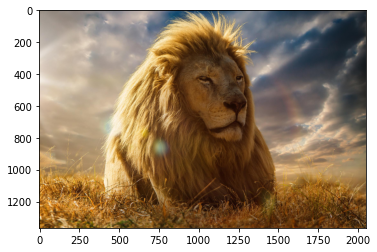

(1365, 2048, 3)


In [2]:
# 높은 해상도를 가진 이미지를 불러옵니다
high_resolution_image = cv2.imread(os.getenv('HOME') + '/aiffel/super_resolution/lion.jpg')
high_resolution_image = cv2.cvtColor(high_resolution_image, cv2.COLOR_BGR2RGB)

plt.imshow(high_resolution_image)
plt.show()
print(high_resolution_image.shape)

#### 저해상도 이미지

(341, 512, 3)


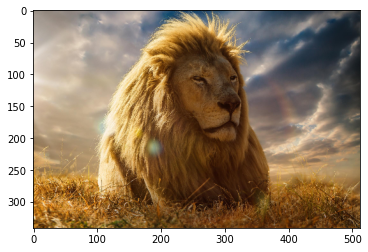

In [3]:
# 저해상도 이미지를 생성해줍니다.
# cv2.resize를 사용해서 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄입니다. 
low_resolution_image = cv2.resize(high_resolution_image, 
                                  dsize = (high_resolution_image.shape[1]//4, high_resolution_image.shape[0]//4))  # (가로 픽셀 수, 세로 픽셀 수)

plt.imshow(low_resolution_image)
print(low_resolution_image.shape)

In [4]:
# SRGAN은 크게 두 개의 신경망(Generator, Discriminator)으로 구성되어 있습니다.
# 테스트에는 저해상도 입력을 넣어 고해상도 이미지를 출력하는 Generator만 이용합니다. 
# 학습 시간이 오래 걸리기 때문에 학습이 완료된 모델을 불러옵니다.
# 모델을 불러오기전, 학습이 완료된 Generator인 srgan_G.h5 파일을 불러옵니다.

model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

#### srgan 이미지

In [5]:
# 테스트 과정을 진행하는 함수를 간단하게 정의합니다.
# apply_srgan함수를 이용해 줄인 저해상도 이미지에 대해 SRGAN의 고해상도 결과를 생성합니다.

def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True
)

for i, (lr, hr) in enumerate(valid):
    if i == 6: break

srgan_image = apply_srgan(low_resolution_image)

#### bicubic 이미지

(1364, 2048, 3)


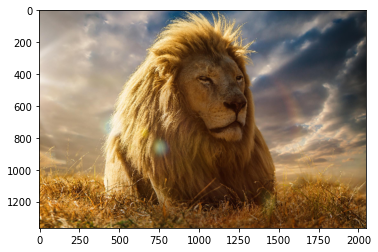

In [6]:
# cv2.resize()를 사용해 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. 
bicubic_interpolation_image = cv2.resize(low_resolution_image, 
                              dsize = (low_resolution_image.shape[1]*4, low_resolution_image.shape[0]*4),
                              interpolation=cv2.INTER_CUBIC) # bicubic 설정  # (가로 픽셀 수, 세로 픽셀 수)
plt.imshow(bicubic_interpolation_image)
print(bicubic_interpolation_image.shape)

#### 이미지 시각화

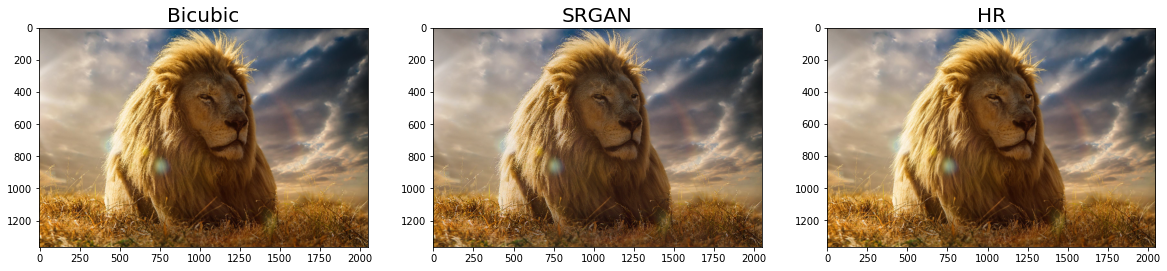

In [7]:
# 3개 이미지(Bicubic의 결과, SRGAN의 결과, 원래 고해상도 이미지)를 나란히 시각화합니다. 
images = [bicubic_interpolation_image, srgan_image, high_resolution_image]
titles = ["Bicubic", "SRGAN", "HR"]

plt.figure(figsize=(20,10)) #18, 5
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

#### 이미지 확대 시각화
- 이미지 크기가 작아서 성능의 차이를 알기 어렵기 때문에 특정 부분을 확대해서 봅시다.
- 먼저 저해상도의 이미지를 확대해봐서 픽셀이 보이는 것을 확인해준다.
#### 저해상도 이미지 확대

In [8]:
# 시각화 하기 위해 이미지의 특정 부분을 잘라내는 함수를 정의합니다.
def crop(image, left_top, x=200, y=200):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

이미지 크기: (50, 50, 3)


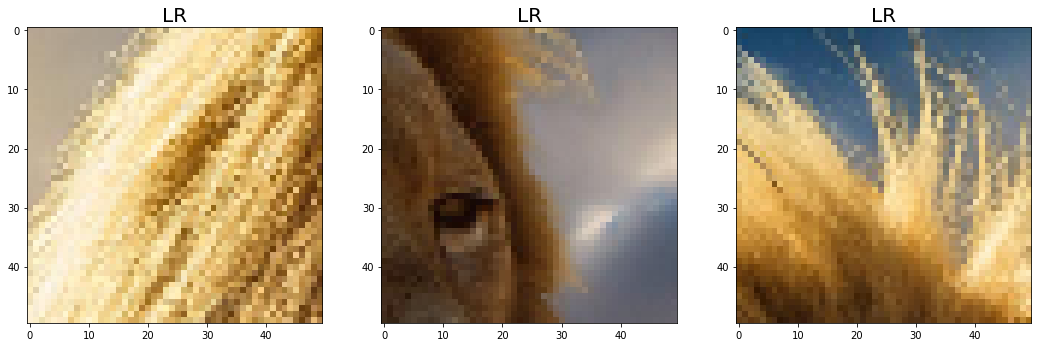

In [9]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(400//4,500//4), (300//4,1200//4), (0,1000//4)]

images = []
for left_top in left_tops:
    img0 = crop(low_resolution_image, left_top, 200//4, 200//4)
    images.extend([img0])

labels = ["LR"] * 3

plt.figure(figsize=(18,18))
for i in range(3):
    plt.subplot(1,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=20)
    
print("이미지 크기:",img0.shape)

- 저해상도의 이미지를 bicubic interpolation, srgan, HR에 각자 통과시켜 본다.

/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


이미지 크기: (200, 200, 3)


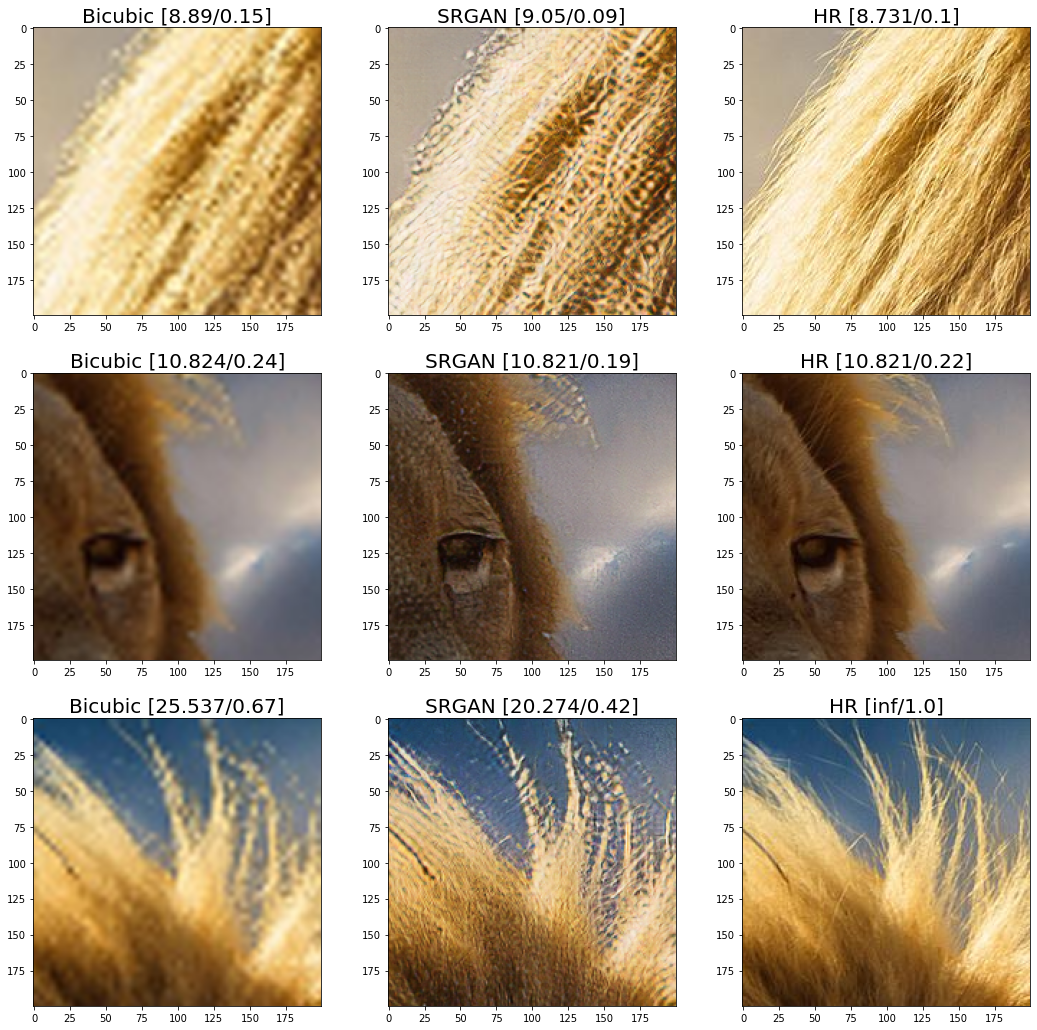

In [13]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.

left_tops = [(400,500), (300,1200), (0,1000)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_interpolation_image, left_top, 200, 200)
    img2 = crop(srgan_image , left_top, 200, 200)
    img3 = crop(high_resolution_image, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRGAN", "HR"] * 3


# 각 이미지에 대해 PSNR을 계산하고 반올림합니다.
psnr = [round(peak_signal_noise_ratio(img3, i), 3) for i in images]
# 각 이미지에 대해 SSIM을 계산하고 반올림합니다.
ssim = [round(structural_similarity(img3, i, multichannel=True), 2) for i in images]


# 이미지 제목에 PSNR과 SSIM을 포함하여 시각화 합니다.
plt.figure(figsize=(18,18))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i] + f" [{psnr[i]}/{ssim[i]}]", fontsize=20)

print("이미지 크기:", img1.shape)

- 원본 이미지라면 HR[inf/1.0]이 나와야하는데 3번째 부분만 정확히 나오고 앞의 두 부분은 그렇지 않은 점이 이상했다.
- 따라서, 각 부분을 분리해서 생각해보기로 했다.

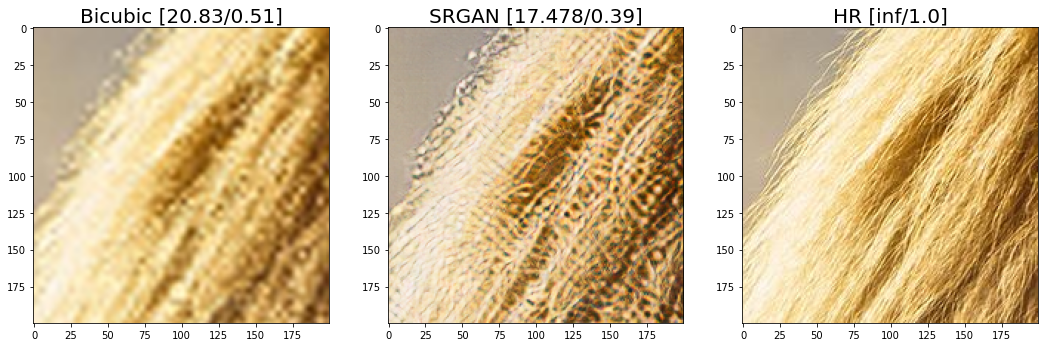

In [16]:
left_tops = [(400,500)]


images = []
for left_top in left_tops:
    img1 = crop(bicubic_interpolation_image, left_top, 200, 200)
    img2 = crop(srgan_image , left_top, 200, 200)
    img3 = crop(high_resolution_image, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRGAN", "HR"] * 3


# 각 이미지에 대해 PSNR을 계산하고 반올림합니다.
psnr = [round(peak_signal_noise_ratio(img3, i), 3) for i in images]
# 각 이미지에 대해 SSIM을 계산하고 반올림합니다.
ssim = [round(structural_similarity(img3, i, multichannel=True), 2) for i in images]


# 이미지 제목에 PSNR과 SSIM을 포함하여 시각화 합니다.
plt.figure(figsize=(18,18))
for i in range(3):
    plt.subplot(1,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i] + f" [{psnr[i]}/{ssim[i]}]", fontsize=20)

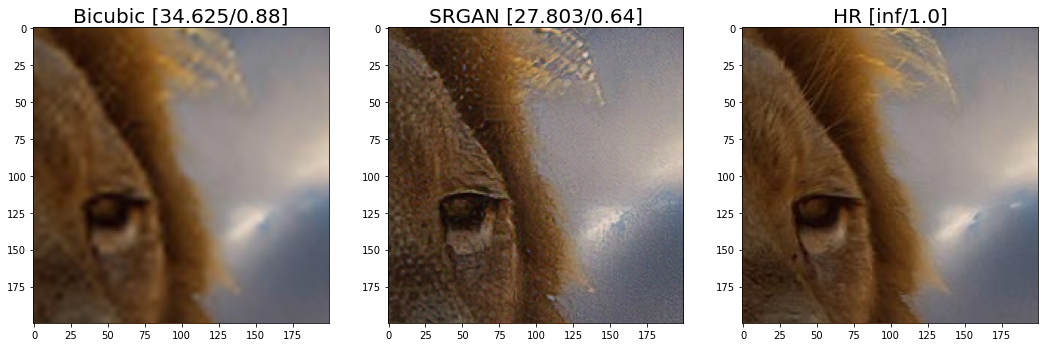

In [15]:
left_tops = [(300,1200)]


images = []
for left_top in left_tops:
    img1 = crop(bicubic_interpolation_image, left_top, 200, 200)
    img2 = crop(srgan_image , left_top, 200, 200)
    img3 = crop(high_resolution_image, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRGAN", "HR"] * 3


# 각 이미지에 대해 PSNR을 계산하고 반올림합니다.
psnr = [round(peak_signal_noise_ratio(img3, i), 3) for i in images]
# 각 이미지에 대해 SSIM을 계산하고 반올림합니다.
ssim = [round(structural_similarity(img3, i, multichannel=True), 2) for i in images]


# 이미지 제목에 PSNR과 SSIM을 포함하여 시각화 합니다.
plt.figure(figsize=(18,18))
for i in range(3):
    plt.subplot(1,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i] + f" [{psnr[i]}/{ssim[i]}]", fontsize=20)

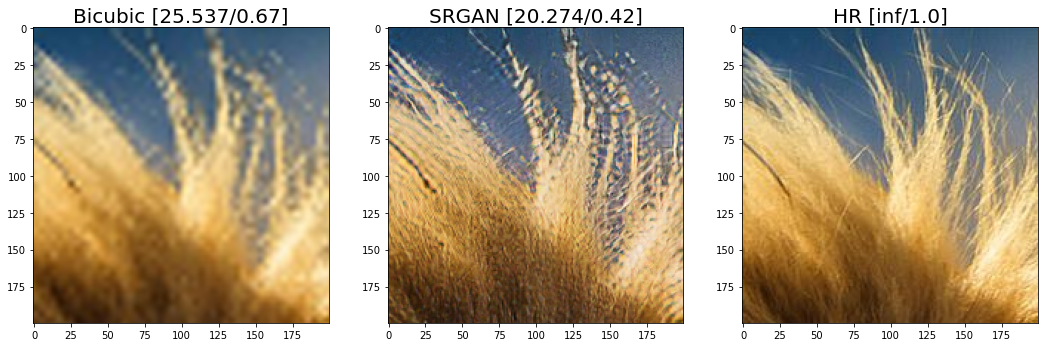

In [17]:
left_tops = [(0,1000)]


images = []
for left_top in left_tops:
    img1 = crop(bicubic_interpolation_image, left_top, 200, 200)
    img2 = crop(srgan_image , left_top, 200, 200)
    img3 = crop(high_resolution_image, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRGAN", "HR"] * 3


# 각 이미지에 대해 PSNR을 계산하고 반올림합니다.
psnr = [round(peak_signal_noise_ratio(img3, i), 3) for i in images]
# 각 이미지에 대해 SSIM을 계산하고 반올림합니다.
ssim = [round(structural_similarity(img3, i, multichannel=True), 2) for i in images]


# 이미지 제목에 PSNR과 SSIM을 포함하여 시각화 합니다.
plt.figure(figsize=(18,18))
for i in range(3):
    plt.subplot(1,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i] + f" [{psnr[i]}/{ssim[i]}]", fontsize=20)

- 맨 오른쪽의 고해상도 이미지를 기준으로 bicubic과 srgan을 통해 고화질로 복원한 이미지를 비교해본다.
- 이미지의 픽셀 수를 (50, 50, 3)에서 (200, 200, 3)로 4배로 늘렸기 때문에 Bicubic과 srgan을 통과한 이미지는 픽셀칸이 저해상도의 이미지에 비해 더 이상 크게 보이지 않는다.
- Bicubic 보간법의 경우 픽셀 사이의 값들을 평균내서 정보가 없는 픽셀 값을 추정해내기 때문에 이미지가 흐릿해진다.
- 그에 비해 srgan의 경우 이미지가 부자연스럽게 선명한 것을 확인할 수 있다. 그 이유는 Generator가 고해상도 이미지를 생성하는 과정에서 Discriminator를 속이기 위해 이미지를 진짜 같이 선명하게 만들도록 학습 되었기 때문이다. 추가로 앞서 설명했듯이 VGG구조를 이용한 content loss를 통해 학습한 것 또한 사실적인 이미지를 형성하는데 크게 기여했다고 한다. 다만, 입력되었던 저해상도 이미지가 매우 제한된 정보를 가지고 있기에 고해상도 이미지와 세부적으로 동일한 모양으로 선명하진 않은 것이다.
- 평가 척도로 PSNR(Peak Signal-to-Noise Ratio)와 SSID(Structural Similarity Index Map)를 사용하였다.
- PSNR이 높을수록 좋고(무한대에 근접할 수록 좋음), SSID(0~1)는 1에 근접할수록 원본 이미지와 유사도가 높다.
- 평가 척도를 사용하기 위해 원본이미지의 화질을 일부러 손상시켜서 비교한 것이다.
- 3부분 모두 Bicubic이 PSNR와 SRGAN이 더 높았다. 
- SSID는 밝기( luminance ), 대비( contrast ), 구조 ( structure )를 고려한 이미지의 유사도를 구하는 방법으로, PSNR이 사람의 지각품질을 제대로 반영하지 못한다는 PSNR의 한계를 극복하기 위한 지표이다. 따라서 SSID가 높은 SRGAN이 우리의 눈에 선명해보인다는 직관과 일치한다.

## 프로젝트 1-2 : 다양한 해상도의 이미지에 대해 시각화를 통해 원본, SRGAN생성본, interpolation생성본을 비교분석
- 저해상도 이미지에 srgan과 interpolation을 적용해봐서 고화질로 변환해본다

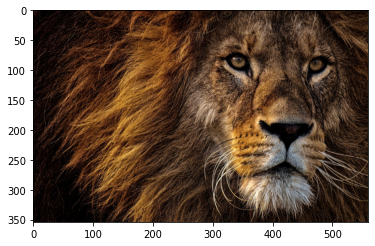

(354, 560, 3)


In [35]:
# 비교적 낮은 해상도를 가진 이미지를 불러옵니다
lion_low_resolution = cv2.imread(os.getenv('HOME') + '/aiffel/super_resolution/lion_low_resolution.jpg')
lion_low_resolution = cv2.cvtColor(lion_low_resolution, cv2.COLOR_BGR2RGB)

plt.imshow(lion_low_resolution)
plt.show()
print(lion_low_resolution.shape)

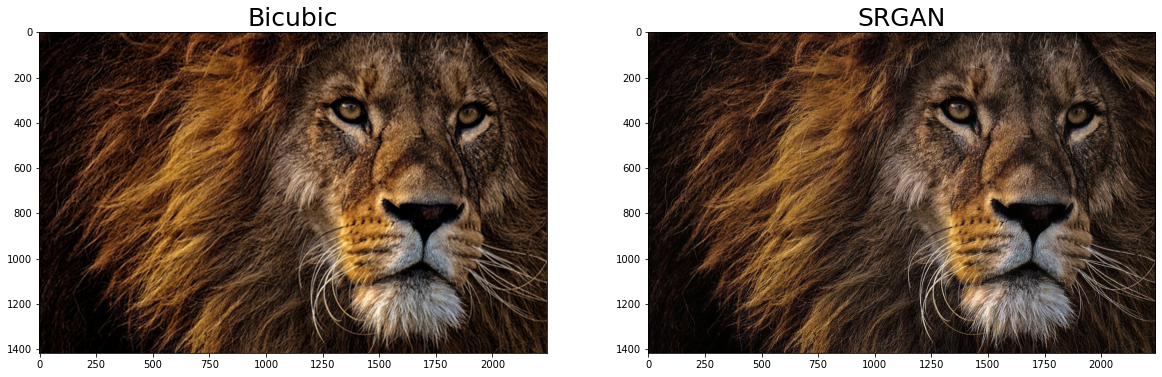

In [36]:
# bicubic_interpolation
# cv2.resize()를 사용해 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. 
lion_bicubic_interpolation = cv2.resize(lion_low_resolution, 
                              dsize = (lion_low_resolution.shape[1]*4, lion_low_resolution.shape[0]*4),
                              interpolation=cv2.INTER_CUBIC) # bicubic 설정  # (가로 픽셀 수, 세로 픽셀 수)

# srgan
lion_srgan = apply_srgan(lion_low_resolution)

# 시각화
images = [lion_bicubic_interpolation, lion_srgan]
titles = ["Bicubic", "SRGAN"]

plt.figure(figsize=(20,10)) 
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,2,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=25)

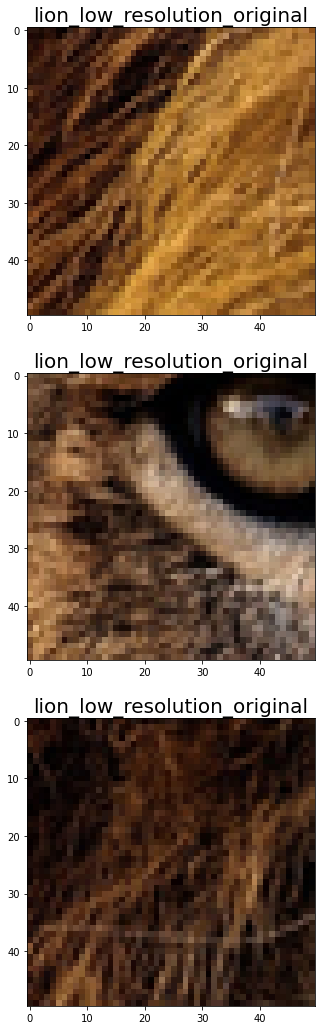

In [37]:
# 원본 이미지 부분 확대 시각화
left_tops = [(400//4,500//4), (300//4,1200//4), (0,1000//4)]

images = []
for left_top in left_tops:
    img0 = crop(lion_low_resolution, left_top, 200//4, 200//4)
    images.extend([img0])

labels = ["lion_low_resolution_original"] * 3

plt.figure(figsize=(18,18))
for i in range(3):
    plt.subplot(3,1,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=20)

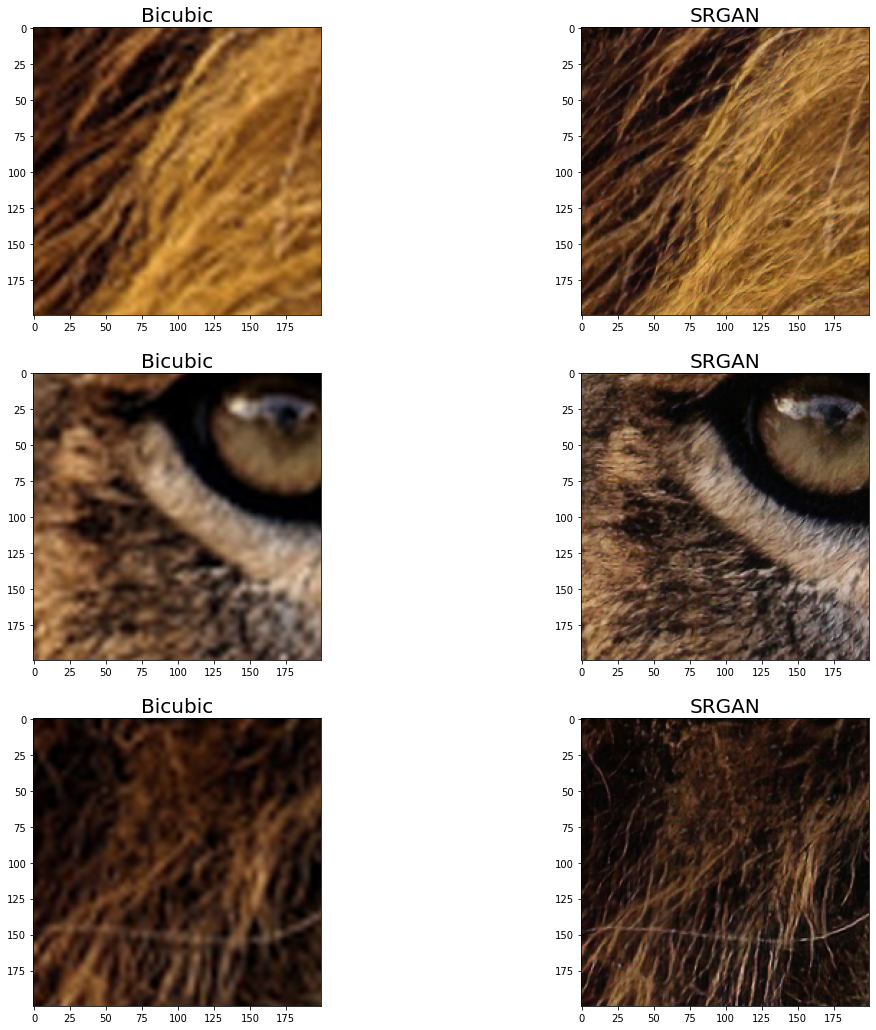

In [38]:
# 부분 확대 시각화
left_tops = [(400,500), (300,1200), (0,1000)]

images = []
for left_top in left_tops:
    img1 = crop(lion_bicubic_interpolation, left_top, 200, 200)
    img2 = crop(lion_srgan, left_top, 200, 200)
    images.extend([img1, img2])

labels = ["Bicubic", "SRGAN"] * 3

plt.figure(figsize=(18,18))
for i in range(6):
    plt.subplot(3,2,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=20)

- 저해상도의 이미지를 가져와서 bicubic interpolation과 SRGAN을 적용했을 때 화질이 상당히 선명해지는 것을 확인할 수 있었다.

## 프로젝트 2 : SRGAN을 이용해 고해상도 gif 생성하기
이전 Super Resolution의 활용 사례에 대해 살펴봤을 때, 단일 이미지가 아닌 영상에 대해 Super Resolution을 적용한 사례가 있었습니다. 이번에는 이미 학습된 SRGAN을 이용해 저해상도 영상을 고해상도 영상으로 바꿔보는 프로젝트를 수행해 봅시다.

실제로 동영상의 Super Resolution은 시간 순서에 따른 다수의 프레임 정보를 고려하는 것이 더 좋지만, 처음부터 학습시키기에 많은 시간이 소요됩니다. 여기서는 이전에 사용했던 SRGAN을 이용해 한 프레임씩 고해상도 이미지로 변환 시켜 모든 프레임에 대해 적용하고, 그 프레임들을 합쳐 동영상으로 만들어 봅시다.

각 프레임들을 모아 gif 파일을 만드는데 아래 라이브러리의 설치가 필요합니다.
#### 1. gif 파일 불러오기

In [33]:
# 다운받은 파일의 경로를 설정해 주세요.
gif_path = os.getenv('HOME') + '/aiffel/super_resolution/'
gif = cv2.VideoCapture(os.path.join(gif_path, 'city_night_lr.gif'))


isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 8
frame 크기 : (255, 500, 3)


#### 2. 프레임별 Super Resolution 진행하기
-Bicubic interpolation과 SRGAN을 이용해 각각의 가로, 세로 픽셀 수를 4배로 늘려봅시다. Super Resolution이 완료된 각각의 결과를 frames_sr이라는 리스트에 넣어주세요.

In [44]:
# bicubic_interpolation
frames_sr_bicubic_interpolation = []
for frame in frames:
    frames_sr_bicubic_interpolation.append(cv2.resize(
        frame, 
        dsize=(frame.shape[1]*4, frame.shape[0]*4), 
        interpolation=cv2.INTER_CUBIC
    ))
    
# SRGAN
frames_sr_srgan = []
for frame in frames:
    frames_sr_srgan.append(apply_srgan(frame))

# Super Resolution이 완료된 결과
frames_sr = [frames_sr_bicubic_interpolation, frames_sr_srgan]

#### 3. 프레임을 합쳐 gif 만들기

In [65]:
imageio.mimsave("high_resolution_bicubic.gif", frames_sr_bicubic_interpolation)
imageio.mimsave("high_resolution_srgan.gif", frames_sr_srgan)

#### 4. Jupyter notebook에 gif 표시하기

In [67]:
#show_gif("high_resolution_bicubic.gif", width=800) # width 는 적당히 큰 값으로 설정해주세요

In [68]:
#show_gif("high_resolution_srgan.gif", width=800) # 위에서 설정한 width와 같은 값으로 설정해주세요

- bicubic interpolation보다 srgan이 이미지상으로도 더 화질일 좋은 것을 확인 할 수 있었다.